In [1]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
import os
import urllib
import shutil

def download_file(url, dir_path="data"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    file_name = os.path.split(url)[-1]
    file_path = os.path.join(dir_path, file_name)
    
    with urllib.request.urlopen(url) as response, open(file_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    return file_path

In [3]:
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

## Трансформация данных (feature selection & feature extraction)

Для повышения качества работы ML моделей можно использовать только часть доступных атрибутов. Процедура выбора наиболее значимых атрибутов называется feature selection. 

Атрибуты можно комбинировать друг с другом. Предположим, что количество выпускаемых на заводе деталей зависит от количества сотрудников и количества конвейеров. В идеале, чем больше сотрудников и конвейеров, тем больше деталей производится. Если мы добавим конвейер, но не добавим на него людей, то никакой пользы от добавления конвейера не будет. Следовательно, в модель нужно добавить атрибут, учитывающий связь между сотрудниками и конвейерами. Поиск комбинаций атрибутов на основе знаний о природе исходных данных называется feature engineering.

# Рекламный бюджет

In [4]:
download_file("http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv")
adv_df = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])
adv_df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [5]:
adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


Выше представлены данные о продажах некоторого продукта (sales, в тысячах штук) в зависимости от рекламного бюджета (в тысячах долларов), потраченного на различные медиа (TV, Radio и Newspapers). Предположим, что вы консультант, которого попросили создать маркетинговый план на следующий год на основе этих данных, так, чтобы продажи продукта были высокими.

 ## Что мы пытаемся понять?

1. Есть ли связь между рекламным бюджетом и продажами?
2. Насколько сильна связь между бюджетом и продажами? Можем ли мы предсказывать продажи на основе бюджета?
3. Какие медиа способствуют продажам?
4. Насколько точно мы можем предсказывать будущие продажи?
6. Линейная ли зависимость между бюджетом и продажами?
7. Есть ли эффект взаимодействия (synergy/interaction effect) между медийными бюджетами?

Мы ответим на эти вопросы, используя только линейную регрессию.

## Выбор модели

In [6]:
from sklearn.linear_model import LinearRegression
import math

In [7]:
adv_df['log_tv'] = adv_df.TV.apply(lambda x: math.log(x, 2))

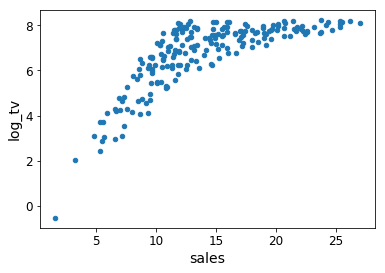

In [8]:
adv_df.plot.scatter('sales', 'log_tv')

In [9]:
adv_df['log_tv'] = adv_df.TV.apply(lambda x: math.pow(x, 0.4))

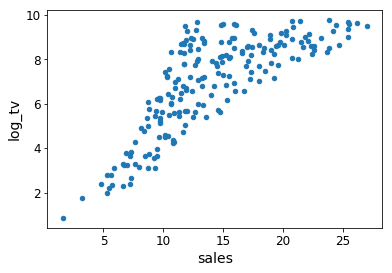

In [10]:
adv_df.plot.scatter('sales', 'log_tv')

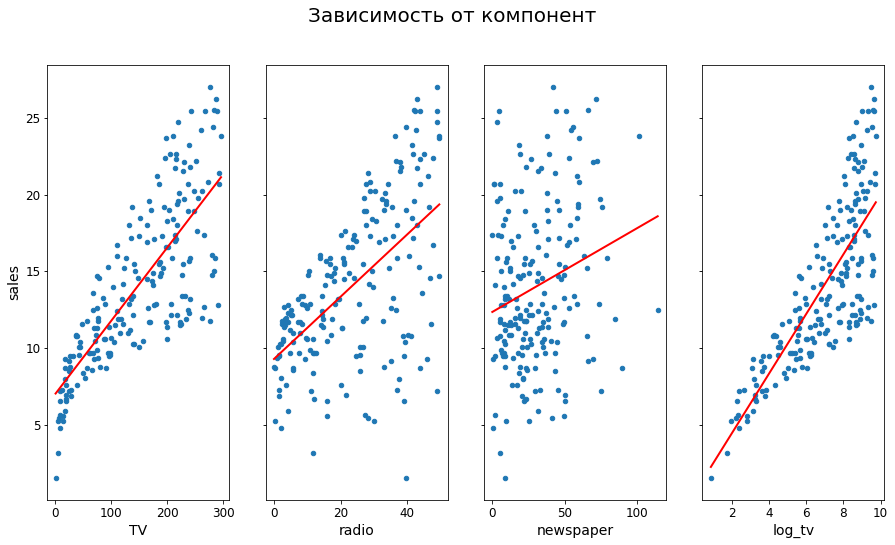

In [11]:
%matplotlib inline

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15,8))
fig.suptitle('Зависимость от компонент', fontsize=20)
y_col = 'sales'


for i, x_col in enumerate(adv_df.columns.drop(y_col)):
    adv_df.plot.scatter(x_col, y_col, ax=axes[i])
    
    lm = LinearRegression().fit(
        adv_df[x_col].values.reshape(-1, 1), 
        adv_df[y_col].values.reshape(-1, 1)
    )
    xs = np.array([adv_df[x_col].min(), adv_df[x_col].max()]).reshape(-1, 1)
    ys = lm.predict(xs)
    axes[i].plot(xs, ys, c='r', linewidth=2)

У нас есть 3 атрибута и мы считаем, что все они полезные. Так как мы используем линейную регрессию, модель будет выглядеть следующим образом:
$$sales = \beta_0 + \beta_1 * TV + \beta_2 * Radio + \beta_3 * Newspaper$$

На данный момент мы опустим тот факт, что медийные бюджеты в нашей модели не влияют друг на друга.

In [12]:
adv_df['total'] = adv_df['TV'] + adv_df['radio'] + adv_df['newspaper']

In [13]:
adv_df.total.head()

0    337.1
1    128.9
2    132.4
3    251.3
4    250.0
Name: total, dtype: float64

In [14]:
import seaborn as sns

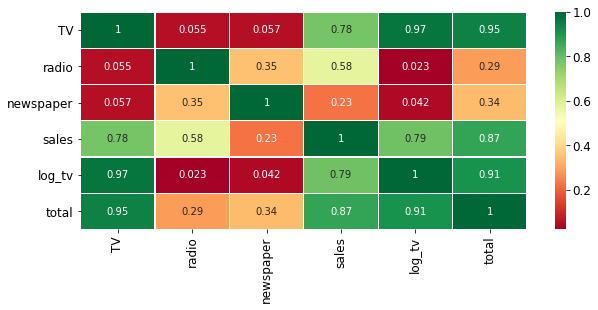

In [15]:
sns.heatmap(adv_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,4)
plt.show()

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


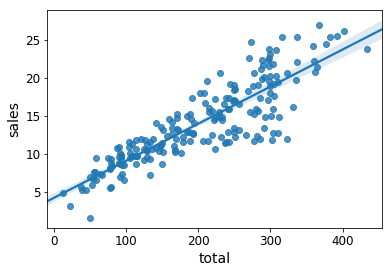

In [16]:
sns.regplot(x= adv_df.total, y=adv_df.sales, data=adv_df, fit_reg=True)

## t-statistcs,  p-value, $R^2$, RSE, F-statistics

Итак, у нас есть линейная модель и мы можем посчитать коэффициенты $\beta_0, \beta_1, \beta_2, \beta_3$. Найдем их (и немного статической информации о работе модели), воспользовавшись библиотечкой statsmodel.

In [17]:
est = smf.ols('sales ~ TV + radio + newspaper + total', data=adv_df).fit()
est_res = est.summary()
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,-0.0125,0.002,-5.146,0.000,-0.017,-0.008
radio,0.1302,0.007,18.272,0.000,0.116,0.144
newspaper,-0.0594,0.006,-10.679,0.000,-0.070,-0.048
total,0.0583,0.002,27.223,0.000,0.054,0.063


### Standard error

Как мы помним, настоящее линейное представление данных выглядит как:
$$y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \dots + \beta_n * x_n + \epsilon$$

где $\epsilon$ - неприводимая ошибка (irreducible error). Поэтому наша модель это аппроксимация вида:
$$\hat{y} = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \dots + \beta_n * x_n$$

Более того, так как мы работаем лишь с сэмплом данных (а не с полным набором), то коэффициенты $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ на самом деле тоже аппроксимация ($\hat{\beta_0}, \hat{\beta_1}, \hat{\beta_2}, \dots, \hat{\beta_n}$). И, конечно, нам интересно знать, насколько она точна. Для этих целей используется *стандартная ошибка*.

Стандартную ошибку можно посчитать для каждого параметра (мы опустим особенности и ограничения этих вычислений). Зная стандартные ошибки, можно вычислить доверительные интервалы. Например, $95\%$ значений $\beta_0$ будут в интервале $[2.324, 3.554]$ (т.е., без какой-либо рекламы с 95% уверенностью мы сможем продавать от $2324$ до $3554$ единиц товара).

### Проверка гипотезы (t-statistics и p-value)

Используя стандартные ошибки, мы можем проверять гипотезы. Наиболее популярный тип проверки - сопоставление *нулевой* и *альтернативной гипотезы*:

$H_0$: между $x_i$ и $y$ нет зависимости

$H_a$: между $x_i$ и $y$ есть зависимость

В нашем случае, математически это выглядит так:
$$
H_0: \beta_i = 0 \\
H_a: \beta_i \ne 0
$$

Для проверки этой гипотезы производится t-тест:
$$t = \frac{\hat{\beta_i} - 0}{SE(\hat{\beta_i})}$$
SE - standard error.

Если между $x_i$ и $y$ нет зависимости, то мы ожидаем, что $t$ будет соответствовать $t$-распределению с $n-2$ степенями свободы ($n$ - количество экземпляров в сэмпле). Таким образом, чтобы подтвердить $H_0$ при известном распределении, нам достаточно найти вероятность того, что наблюдаемое значение $\ge |t|$ при условии, что $\beta_i = 0$. Данная вероятность называется $p$-value.

Если $p$-value достаточно маленький (обычно меньше $1\%$), то мы можем отклонить нулевую гипотезу. 

In [18]:
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,-0.0125,0.002,-5.146,0.000,-0.017,-0.008
radio,0.1302,0.007,18.272,0.000,0.116,0.144
newspaper,-0.0594,0.006,-10.679,0.000,-0.070,-0.048
total,0.0583,0.002,27.223,0.000,0.054,0.063


В нашем случае все медиа, кроме Newspapers, имеют маленький $p$-value. Т.е. между Newspaper и Sales нет линейной зависимости и, следовательно, этого атрибута можно избавиться.

Недостатком определения полезности атрибутов с использованием t-statistics является то, что оценка важности каждого атрибута производится независимо от других, что может быть ошибочно.

### $R^2$

Линейная регрессия минимизирует метрику RSS (residual sum of squares), которая равна сумме квадратов наблюдаемых ошибок:
$$RSS = \sum_{i = 1}^n(y_i - \hat{y_i})^2$$

К сожалению, данная величина абсолютная и по ней сложно определить качество модели. Поэтому качество линейной регрессии часто оценивают при помощи двух других метрик: RSE (residual standard error) и $R^2$.
$$RSE = \sqrt{\frac{1}{n-p-1}RSS}$$

$$R^2 = \frac{TSS - RSS}{TSS} = 1 - \frac{RSS}{TSS}, \quad TSS = \sum_{i = 1}^n(y_i - \bar{y})^2$$

$TSS$ - total sum of squares, $p$ - количество переменных.

* RSE - штрафует модели, которым нужно больше предсказателей (predictors) для достижения одинаковых значения RSS.
* $R^2$ - показывает, какой процент вариативности (variance) объяснен моделью.

Т.е. мы минимизируем RSE и максимизируем $R^2$. $R^2 \in [0, 1]$ - относительная величина, чем ближе к 1, тем лучше.

Чем проще модель, тем лучше она обобщает. Поэтому в нашем примере модель, в которой есть только TV и Radio, лучше модели с TV, Radio и Newspaper (приблизительно одинаковые $R^2$ и меньший $RSE$). 

**Внимание!!!** Все метрики были посчитаны для тренировочных данных.

# Итак, мы показали, что нам не нужны газеты. Посмотрим, что у нас получилось.

In [19]:
adv_df.columns

Index(['TV', 'radio', 'newspaper', 'sales', 'log_tv', 'total'], dtype='object')

In [20]:
lm = LinearRegression().fit(
    adv_df[['TV', 'radio']].as_matrix(),
    adv_df["sales"]
)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [21]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(TV, Radio, indexing='xy')
Z = np.zeros((Radio.size, TV.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =(lm.intercept_ + B1[i,j] * lm.coef_[0] + B2[i,j] * lm.coef_[1])

Text(0.5, 0, 'sales')

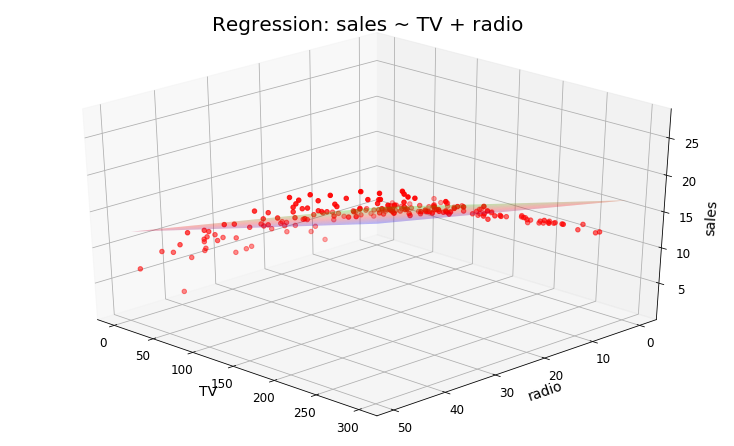

In [22]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: sales ~ TV + radio', fontsize=20)

ax = axes3d.Axes3D(fig, azim=135, elev=30)
ax.plot_surface(B1, B2, Z, rstride=5, cstride=5, alpha=0.3, cmap=plt.cm.brg)
ax.scatter3D(adv_df.TV, adv_df.radio, adv_df.sales, c='r')
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')

Как видно из изображения, апроксимирующая плоскость переоценивает значения Sales для случаев, когда точки находятся рядом с одной из осей (т.е. зависят только от одного медиа) и недооценивает Sales в случае, когда бюджет разделен между двумя медиа.

In [23]:
lm = LinearRegression().fit(
    adv_df[['log_tv', 'radio']].as_matrix(),
    adv_df["sales"]
)

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(x, y)
# y_pred = model.predict(x)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [24]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,10)

B1, B2 = np.meshgrid(TV, Radio, indexing='xy')
Z = np.zeros((Radio.size, TV.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =(lm.intercept_ + B1[i,j] * lm.coef_[0] + B2[i,j] * lm.coef_[1])

Text(0.5, 0, 'sales')

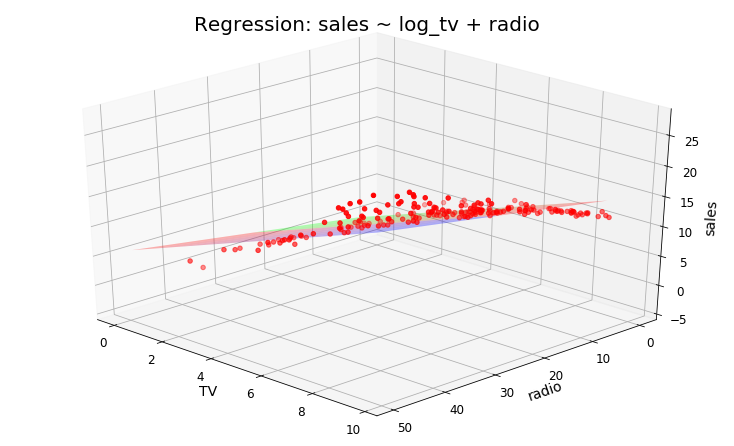

In [25]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: sales ~ log_tv + radio', fontsize=20)

ax = axes3d.Axes3D(fig, azim=135, elev=30)
ax.plot_surface(B1, B2, Z, rstride=5, cstride=5, alpha=0.3, cmap=plt.cm.brg)
ax.scatter3D(adv_df.log_tv, adv_df.radio, adv_df.sales, c='r')
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')

# Домашнее задание

1. Разделить дата сет на трейн и тест в отношение 50:50 70:30 80:20 (с перемешиванием)
2. Обучать наши модели на трейне. Предсказывать и замерять метрику R^2 и на трейне и на тесте
3. Проверить следующие модели, для каждого разделения:
    а) sales ~ log_tv + radio
    б) sales ~ TV + radio
    в) sales ~ TV + radio + newspaper

#### 1. Разделить дата сет на трейн и тест в отношение 50:50 70:30 80:20 (с перемешиванием)

In [26]:
# случайно выбираем уникальные индексы
test_50 = np.random.choice(adv_df.index.unique(), size=100, replace=False)
test_50_set = set(test_50)

In [27]:
test_50

array([ 95,  15,  30, 158, 128, 115,  69, 170, 174,  45,  66, 182, 165,
        78, 186, 177,  56, 152,  82,  68, 124,  16, 148,  93,  65,  60,
        84,  67, 125, 132,   9,  18,  55,  75, 150, 104, 135, 137, 164,
        76,  79, 197,  38,  24, 122, 195,  29,  19, 143,  86, 114, 173,
         5, 126, 117,  73, 140,  98, 172,  96, 169,  97,  31,  12,  35,
       119,  42, 189,  90, 136,  51, 127, 162,  41, 118, 113,  26, 139,
       100, 111,   2,  77,  46, 187, 191,  85, 161,  36, 190,  61,  22,
       141, 101,  33,  11, 194, 159,   6,  27, 120], dtype=int64)

In [28]:
train_50 = adv_df[~adv_df.index.isin(test_50)].copy()
print("Total transactions in train dataset: ", len(train_50))

test_50_t = adv_df[adv_df.index.isin(test_50)].copy()
print("Total transactions in test dataset: ", len(test_50_t))

Total transactions in train dataset:  100
Total transactions in test dataset:  100


In [29]:
# с помощью метода train_test_split
from sklearn.model_selection import train_test_split

In [30]:
train_70, test_30 = train_test_split(adv_df, test_size=0.3, shuffle=True)

In [31]:
test_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 176 to 22
Data columns (total 6 columns):
TV           60 non-null float64
radio        60 non-null float64
newspaper    60 non-null float64
sales        60 non-null float64
log_tv       60 non-null float64
total        60 non-null float64
dtypes: float64(6)
memory usage: 3.3 KB


In [32]:
train_70.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 106 to 146
Data columns (total 6 columns):
TV           140 non-null float64
radio        140 non-null float64
newspaper    140 non-null float64
sales        140 non-null float64
log_tv       140 non-null float64
total        140 non-null float64
dtypes: float64(6)
memory usage: 7.7 KB


In [33]:
train_80, test_20 = train_test_split(adv_df, test_size=0.2, shuffle=True)

In [34]:
test_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 160 to 53
Data columns (total 6 columns):
TV           40 non-null float64
radio        40 non-null float64
newspaper    40 non-null float64
sales        40 non-null float64
log_tv       40 non-null float64
total        40 non-null float64
dtypes: float64(6)
memory usage: 2.2 KB


#### 2. Обучать наши модели на трейне. Предсказывать и замерять метрику R^2 и на трейне и на тесте

обучаем модель по log_tv+radio (она наиболее удачная как помним из занятия) на трейнах и создаем параметр с значением предсказанной sales
считаем R2

In [35]:
x_50_lm_tr = smf.ols('sales ~ log_tv + radio', train_50).fit()

x_50_lm_tt = smf.ols('sales ~ log_tv + radio', test_50_t).fit()

print("R^2 train:", x_50_lm_tr.rsquared)
print("R^2 test:", x_50_lm_tt.rsquared)

R^2 train: 0.9273049082016976
R^2 test: 0.9368194886475539


In [36]:
x_70_lm_tr = smf.ols('sales ~ log_tv + radio', train_70).fit()

x_70_lm_tt = smf.ols('sales ~ log_tv + radio', test_30).fit()

print("R^2 train:", x_70_lm_tr.rsquared)
print("R^2 test:", x_70_lm_tt.rsquared)

R^2 train: 0.9317607614434742
R^2 test: 0.933798648674478


In [37]:
x_80_lm_tr = smf.ols('sales ~ log_tv + radio', train_80).fit()

x_80_lm_tt = smf.ols('sales ~ log_tv + radio', test_20).fit()

print("R^2 train:", x_80_lm_tr.rsquared)
print("R^2 test:", x_80_lm_tt.rsquared)

R^2 train: 0.9334263202337125
R^2 test: 0.9379796800162735


#### 3. Проверить следующие модели, для каждого разделения:
    а) sales ~ log_tv + radio
    б) sales ~ TV + radio
    в) sales ~ TV + radio + newspaper

In [38]:
from sklearn.metrics import r2_score

In [39]:
# используем метод LinearRegression().fit() для обучения моделей a, б и в
# A

lm_50 = LinearRegression().fit(
    train_50[['log_tv', 'radio']].as_matrix(),
    train_50['sales'])

lm_70 = LinearRegression().fit(
    train_70[['log_tv', 'radio']].as_matrix(),
    train_70['sales'])

lm_80 = LinearRegression().fit(
    train_80[['log_tv', 'radio']].as_matrix(),
    train_80['sales'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [40]:
# записываем пресказание в новый столбец
test_50_t['test_predict'] = lm_50.predict(test_50_t[['log_tv', 'radio']].as_matrix())
test_30['test_predict'] = lm_70.predict(test_30[['log_tv', 'radio']].as_matrix())
test_20['test_predict'] = lm_80.predict(test_20[['log_tv', 'radio']].as_matrix())

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-pac

In [41]:
# B
lm_70_b = LinearRegression().fit(
    train_70[['TV', 'radio']].as_matrix(),
    train_70['sales'])

lm_50_b = LinearRegression().fit(
    train_50[['TV', 'radio']].as_matrix(),
    train_50['sales'])

lm_80_b = LinearRegression().fit(
    train_80[['TV', 'radio']].as_matrix(),
    train_80['sales'])


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [42]:
test_30['test_predict_b'] = lm_70_b.predict(test_30[['TV', 'radio']].as_matrix())
test_50_t['test_predict_b'] = lm_50_b.predict(test_50_t[['TV', 'radio']].as_matrix())
test_20['test_predict_b'] = lm_80_b.predict(test_20[['TV', 'radio']].as_matrix())

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launch

In [46]:
# C
lm_70_c = LinearRegression().fit(
    train_70[['TV', 'radio', 'newspaper']].as_matrix(),
    train_70['sales'])

lm_50_c = LinearRegression().fit(
    train_50[['TV', 'radio', 'newspaper']].as_matrix(),
    train_50['sales'])
    
lm_80_c = LinearRegression().fit(
    train_80[['TV', 'radio', 'newspaper']].as_matrix(),
    train_80['sales'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [47]:
test_50_t['test_predict_c'] = lm_50_c.predict(test_50_t[['TV', 'radio', 'newspaper']].as_matrix())
test_20['test_predict_c'] = lm_80_c.predict(test_20[['TV', 'radio', 'newspaper']].as_matrix())
test_30['test_predict_c'] = lm_70_c.predict(test_30[['TV', 'radio', 'newspaper']].as_matrix())

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is tr

70/30

In [48]:
tmp_a = r2_score(test_30['sales'], test_30['test_predict'])
tmp_b = r2_score(test_30['sales'], test_30['test_predict_b'])
tmp_c = r2_score(test_30['sales'], test_30['test_predict_c'])

print('R2_a', tmp_a)
print('R2_b', tmp_b)
print('R2_c', tmp_c)

R2_a 0.9285447614034006
R2_b 0.8917155605538738
R2_c 0.8917349545995311


50/50

In [49]:
tmp_a_5 = r2_score(test_50_t['sales'], test_50_t['test_predict'])
tmp_b_5 = r2_score(test_50_t['sales'], test_50_t['test_predict_b'])
tmp_c_5 = r2_score(test_50_t['sales'], test_50_t['test_predict_c'])

print('R2_a', tmp_a_5)
print('R2_b', tmp_b_5)
print('R2_c', tmp_c_5)

R2_a 0.9310741259261295
R2_b 0.8826436017134701
R2_c 0.8721004816045134


80/20

In [50]:
tmp_a_8 = r2_score(test_20['sales'], test_20['test_predict'])
tmp_b_8 = r2_score(test_20['sales'], test_20['test_predict_b'])
tmp_c_8 = r2_score(test_20['sales'], test_20['test_predict_c'])

print('R2_a', tmp_a_8)
print('R2_b', tmp_b_8)
print('R2_c', tmp_c_8)

R2_a 0.9180392374680408
R2_b 0.882687494788288
R2_c 0.8819438390888497


модель регрессии по log_tv и radio лучше максимизирет R2